# GNN Model

## Imports and Setup

In [ ]:
# Core libraries
import io
import os
import sys
import toml
import pprint
import importlib

# Scientific stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# JARVIS dataset utilities
from jarvis.db.figshare import data

# Plotting setup
import matplotlib
%matplotlib inline
from matplotlib.gridspec import GridSpec

# Progess bar
from tqdm import tqdm

## Configuration

In [ ]:
# Load configuration from TOML file
CONFIG_PATH = "config_multimodal.toml"
config = toml.load(CONFIG_PATH)

print("Project Configuration:")
pprint.pprint(config)

# Add system path for custom modules
SYS_PATH = config.get('system', {}).get('path', './')
sys.path.append(SYS_PATH)  # e.g., .../code/jarvis/

# Add helper for model config
model_cfg = config["model"]


Project Configuration:
{'data': {'dataset_name': 'dft_3d', 'store_dir': '/shared/data/jarvis'},
 'filters': {'bandgap_column': 'optb88vdw_bandgap',
             'ehull': 0.1,
             'max_eps': 10.0,
             'min_eps': 1.0,
             'semiconductor_max': 4.0,
             'semiconductor_min': 0.5,
             'toxic_elements': ['Pb', 'Cd', 'Hg', 'As', 'Se'],
             'transparent_min': 3.0},
 'logging': {'enable': True,
             'file': '/shared/data/jarvis/project_multimodal.log',
             'level': 'INFO'},
 'model': {'categorical': {'crys': {'embed_dim': 4, 'vocab_size': 8},
                           'dimensionality': {'embed_dim': 4, 'vocab_size': 8},
                           'func': {'embed_dim': 1, 'vocab_size': 2},
                           'spg_number': {'embed_dim': 50, 'vocab_size': 214},
                           'typ': {'embed_dim': 1, 'vocab_size': 2}},
           'checkpoint': {'path': ''},
           'devices': {'model': 'cpu'},
           '

## Custom Utilities and Dataset

In [ ]:
from jarvis_utils import load_or_fetch_dataset
from logger_utils import setup_logger, flush_logger

# Setup logger
logger = setup_logger(config)
logger.info("Project configuration loaded.")
logger.info(f"Dataset: {config['data']['dataset_name']}")
logger.info(f"Store directory: {config['data']['store_dir']}")

# Load dataset
df = load_or_fetch_dataset(config["data"]["dataset_name"], data, config["data"]["store_dir"])
logger.info(f"Dataset shape: {df.shape}")

2025-12-11 20:21:35,705 - jarvis_project - INFO - Project configuration loaded.
2025-12-11 20:21:35,705 - jarvis_project - INFO - Dataset: dft_3d
2025-12-11 20:21:35,705 - jarvis_project - INFO - Store directory: /shared/data/jarvis
2025-12-11 20:21:36,967 - jarvis_project - INFO - Dataset shape: (75993, 64)


Dataset shape: (75993, 64)


In [ ]:
df.columns

Index(['jid', 'spg_number', 'spg_symbol', 'formula',
       'formation_energy_peratom', 'func', 'optb88vdw_bandgap', 'atoms',
       'slme', 'magmom_oszicar', 'spillage', 'elastic_tensor',
       'effective_masses_300K', 'kpoint_length_unit', 'maxdiff_mesh',
       'maxdiff_bz', 'encut', 'optb88vdw_total_energy', 'epsx', 'epsy', 'epsz',
       'mepsx', 'mepsy', 'mepsz', 'modes', 'magmom_outcar', 'max_efg',
       'avg_elec_mass', 'avg_hole_mass', 'icsd', 'dfpt_piezo_max_eij',
       'dfpt_piezo_max_dij', 'dfpt_piezo_max_dielectric',
       'dfpt_piezo_max_dielectric_electronic',
       'dfpt_piezo_max_dielectric_ionic', 'max_ir_mode', 'min_ir_mode',
       'n-Seebeck', 'p-Seebeck', 'n-powerfact', 'p-powerfact', 'ncond',
       'pcond', 'nkappa', 'pkappa', 'ehull', 'Tc_supercon', 'dimensionality',
       'efg', 'xml_data_link', 'typ', 'exfoliation_energy', 'spg', 'crys',
       'density', 'poisson', 'raw_files', 'nat', 'bulk_modulus_kv',
       'shear_modulus_gv', 'mbj_bandgap', 'hse_ga

## Candidate Filtering

In [ ]:
def add_candidate_column(df: pd.DataFrame, config: dict) -> pd.DataFrame:
    df = df.copy()

    bandgap_col   = config["filters"]["bandgap_column"]
    sem_min       = config["filters"]["semiconductor_min"]
    sem_max       = config["filters"]["semiconductor_max"]
    trans_min     = config["filters"]["transparent_min"]
    toxic_elements = config["filters"]["toxic_elements"]

    df[bandgap_col] = pd.to_numeric(df[bandgap_col], errors="coerce")
    in_semiconductor_range = df[bandgap_col].between(sem_min, sem_max)
    is_transparent = df[bandgap_col] > trans_min

    if "ehull" in df.columns:
        df["ehull"] = pd.to_numeric(df["ehull"], errors="coerce")
        is_stable = df["ehull"] < config["filters"]["ehull"]
    else:
        is_stable = True

    if "formula" in df.columns:
        tokens = df["formula"].fillna("").astype(str).str.findall(r"[A-Z][a-z]?")
        has_toxic = tokens.apply(lambda t: any(el in t for el in toxic_elements))
    else:
        has_toxic = False

    df["is_candidate"] = (
        in_semiconductor_range &
        is_transparent &
        is_stable &
        (has_toxic == False)
    ).astype(int)

    return df

# Apply candidate filter
config_cand = {
    "filters": {
        "bandgap_column": "optb88vdw_bandgap",
        "semiconductor_min": 0.5,
        "semiconductor_max": 5.0,
        "transparent_min": 2.5,
        "toxic_elements": ["Pb", "Cd", "As", "Hg"],
        "ehull": 0.1
    }
}

df = add_candidate_column(df, config_cand)
df = df.rename(columns={"is_candidate": "target"})


## Data Cleaning

In [ ]:
# Access numeric columns from the TOML config
numeric_cols = config["model"]["num_cols"]

# Force numeric dtype, coerce errors to NaN
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

# Optionally fill NaNs with 0 or column mean
df[numeric_cols] = df[numeric_cols].fillna(0.0)

## Model Definition (Multimodal)

In [ ]:
# Multimodal model - numeric + categorical + formula + graph (LayerNorm fix)

import re
import ast
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from jarvis.core.atoms import Atoms

# ----------------------------
# Helpers: element vocab & formula counts
# ----------------------------
def build_element_vocab(df, max_elements=89):
    elems = set()
    if "formula" in df.columns:
        tokens = df["formula"].fillna("").astype(str).str.findall(r"[A-Z][a-z]?")
        for t in tokens:
            elems.update(t)
    elems = sorted(list(elems))
    vocab = {}
    start_idx = 0
    if len(elems) + 1 > max_elements:
        vocab["UNK"] = 0
        start_idx = 1
    for i, e in enumerate(elems[: max_elements - start_idx]):
        vocab[e] = i + start_idx
    return vocab

def formula_to_counts(formula, element_vocab, num_elements):
    counts = np.zeros(num_elements, dtype=np.float32)
    if not isinstance(formula, str):
        return counts
    tokens = re.findall(r"([A-Z][a-z]?)(\d*\.?\d*)", formula)
    for sym, num in tokens:
        idx = element_vocab.get(sym, element_vocab.get("UNK", None))
        if idx is None:
            continue
        val = float(num) if num not in ("", None) else 1.0
        counts[idx] += val
    return counts

# ----------------------------
# Graph building from atoms_obj
# ----------------------------
def atoms_to_graph(atoms_obj, radius=5.0, max_neighbors=None, element_vocab=None, num_elements=89, device="cpu"):
    cart_coords = np.array(atoms_obj.cart_coords)
    species = atoms_obj.elements
    N = len(species)

    node_idx = np.array([element_vocab.get(sym, element_vocab.get("UNK", 0)) for sym in species], dtype=np.int64)

    edge_src, edge_dst, edge_attr = [], [], []
    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            rij = cart_coords[j] - cart_coords[i]
            dist = np.linalg.norm(rij)
            if dist <= radius:
                inv = 1.0 / dist if dist > 1e-8 else 0.0
                unit = rij / dist if dist > 1e-8 else np.zeros(3)
                feat = [dist, inv, unit[0], unit[1]]  # edge_feat_dim=4
                edge_src.append(i); edge_dst.append(j); edge_attr.append(feat)

    if max_neighbors is not None and len(edge_src) > 0:
        capped_src, capped_dst, capped_attr = [], [], []
        edges_by_src = {}
        for s, d, a in zip(edge_src, edge_dst, edge_attr):
            edges_by_src.setdefault(s, []).append((d, a))
        for s, lst in edges_by_src.items():
            lst_sorted = sorted(lst, key=lambda x: x[1][0])[:max_neighbors]
            for d, a in lst_sorted:
                capped_src.append(s); capped_dst.append(d); capped_attr.append(a)
        edge_src, edge_dst, edge_attr = capped_src, capped_dst, capped_attr

    x = torch.tensor(node_idx, dtype=torch.long, device=device)
    if len(edge_src) == 0:
        edge_index = torch.empty((2, 0), dtype=torch.long, device=device)
        edge_attr_t = torch.empty((0, 4), dtype=torch.float32, device=device)
    else:
        edge_index = torch.stack([
            torch.tensor(edge_src, dtype=torch.long, device=device),
            torch.tensor(edge_dst, dtype=torch.long, device=device)
        ], dim=0)  # (2, E)
        edge_attr_t = torch.tensor(edge_attr, dtype=torch.float32, device=device)  # (E, 4)

    return {"x": x, "edge_index": edge_index, "edge_attr": edge_attr_t}

# ----------------------------
# Embedding modules
# ----------------------------
class FormulaEmbedder(nn.Module):
    def __init__(self, num_elements, embed_dim):
        super().__init__()
        self.emb = nn.Embedding(num_elements, embed_dim)

    def forward(self, element_counts):
        idx = torch.arange(element_counts.shape[-1], device=element_counts.device)
        weights = element_counts.float().unsqueeze(-1)
        vecs = self.emb(idx)
        return (vecs * weights).sum(dim=0)

class SimpleGraphEncoder(nn.Module):
    def __init__(self, num_elements, atom_embed_dim, edge_feat_dim=4):
        super().__init__()
        self.atom_emb = nn.Embedding(num_elements, atom_embed_dim)
        self.msg1 = nn.Linear(atom_embed_dim + edge_feat_dim, atom_embed_dim)
        self.msg2 = nn.Linear(atom_embed_dim + edge_feat_dim, atom_embed_dim)
        self.node_up1 = nn.Linear(atom_embed_dim, atom_embed_dim)
        self.node_up2 = nn.Linear(atom_embed_dim, atom_embed_dim)

    def _normalize_edge_index(self, edge_index):
        if edge_index.numel() == 0:
            return edge_index
        if edge_index.ndim == 1:
            E = edge_index.numel() // 2
            edge_index = edge_index.view(2, E)
        elif edge_index.ndim == 2:
            if edge_index.shape[0] == 2:
                pass
            elif edge_index.shape[1] == 2:
                edge_index = edge_index.t()
            else:
                raise ValueError(f"Unexpected edge_index shape: {tuple(edge_index.shape)}")
        else:
            raise ValueError(f"Unexpected edge_index ndim: {edge_index.ndim}")
        return edge_index

    def message_pass(self, x, edge_index, edge_attr):
        if edge_index.numel() == 0:
            return x
        edge_index = self._normalize_edge_index(edge_index)
        src, dst = edge_index
        E = edge_index.shape[1]
        if edge_attr.ndim == 1:
            edge_attr = edge_attr.view(E, -1)
        elif edge_attr.ndim == 2 and edge_attr.shape[0] != E and edge_attr.shape[1] == E:
            edge_attr = edge_attr.t()
        elif edge_attr.ndim != 2 or edge_attr.shape[0] != E:
            raise ValueError(f"edge_attr shape mismatch: {tuple(edge_attr.shape)} vs E={E}")
        x_src = x[src]
        m = torch.cat([x_src, edge_attr], dim=-1)
        m = F.relu(self.msg1(m))
        agg = torch.zeros_like(x)
        agg.index_add_(0, dst, m)
        x = F.relu(self.node_up1(x + agg))
        x_src = x[src]
        m = torch.cat([x_src, edge_attr], dim=-1)
        m = F.relu(self.msg2(m))
        agg = torch.zeros_like(x)
        agg.index_add_(0, dst, m)
        x = F.relu(self.node_up2(x + agg))
        return x

    def forward(self, graph):
        x = self.atom_emb(graph["x"])
        x = self.message_pass(x, graph["edge_index"], graph["edge_attr"])
        return x.mean(dim=0) if x.shape[0] > 0 else torch.zeros(self.atom_emb.embedding_dim, device=x.device)

class CategoricalEmbeddings(nn.Module):
    def __init__(self, cat_cfg):
        super().__init__()
        self.embeddings = nn.ModuleDict({
            name: nn.Embedding(params["vocab_size"], params["embed_dim"])
            for name, params in cat_cfg.items()
        })

    def forward(self, X_cat_dict):
        embs = [self.embeddings[name](X_cat_dict[name]) for name in self.embeddings]
        return torch.cat([e if e.dim() > 1 else e.unsqueeze(0) for e in embs], dim=-1)


In [ ]:
# ----------------------------
# Full multimodal model (LayerNorm) -- refactored for batched graphs
# ----------------------------
class CandidateNetMultimodal(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.cfg = config

        self.num_proj = nn.Identity()
        self.cat_emb = CategoricalEmbeddings(config["categorical"])
        cat_total_dim = sum([p["embed_dim"] for p in config["categorical"].values()])

        self.formula_emb = FormulaEmbedder(
            config["formula"]["num_elements"],
            config["formula"]["embed_dim"]
        )
        self.graph_enc = SimpleGraphEncoder(
            config["formula"]["num_elements"],
            config["graph"]["atom_embed_dim"],
            config["graph"]["edge_feat_dim"]
        )

        in_dim = (
            len(config["num_cols"])
            + cat_total_dim
            + config["formula"]["embed_dim"]
            + config["graph"]["atom_embed_dim"]
        )

        # Replace BatchNorm1d with LayerNorm to support batch_size=1
        self.fc = nn.Sequential(
            nn.Linear(in_dim, config["mlp"]["hidden1"]),
            nn.LayerNorm(config["mlp"]["hidden1"]),
            nn.ReLU(),
            nn.Dropout(p=config["mlp"]["dropout"]),
            nn.Linear(config["mlp"]["hidden1"], config["mlp"]["hidden2"]),
            nn.LayerNorm(config["mlp"]["hidden2"]),
            nn.ReLU(),
            nn.Linear(config["mlp"]["hidden2"], 1)
        )

    def forward(self, X_num, X_cat_dict, formula_counts, graphs):
        # Numeric + categorical
        x_num = self.num_proj(X_num.float()).view(X_num.size(0), -1)
        x_cat = self.cat_emb(X_cat_dict).view(X_num.size(0), -1)

        # Formula embeddings
        if formula_counts.dim() == 2:
            # Each row is a count vector → embed → (embed_dim,)
            formula_list = [self.formula_emb(fc) for fc in formula_counts]
            x_formula = torch.stack(formula_list, dim=0)  # (batch_size, embed_dim)
        else:
            x_formula = self.formula_emb(formula_counts).unsqueeze(0)  # (1, embed_dim)

        # Graph embeddings
        graph_outputs = []
        for g in graphs:
            xg = self.graph_enc(g)  # (embed_dim,) or (1, embed_dim)
            if xg.dim() == 1:
                xg = xg.unsqueeze(0)  # (1, embed_dim)
            graph_outputs.append(xg)
        x_graph = torch.cat(graph_outputs, dim=0)  # (batch_size, embed_dim)

        # Concatenate all modalities → (batch_size, total_dim)
        x = torch.cat([x_num, x_cat, x_formula, x_graph], dim=-1)
        return self.fc(x).squeeze(-1)


    def predict_proba(self, *args, **kwargs):
        logits = self.forward(*args, **kwargs)
        return torch.sigmoid(logits)


## Data Prep

In [ ]:
# Data Prep for Multimodal GNN Model

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from tqdm import tqdm
import matplotlib.pyplot as plt



device = torch.device(model_cfg["devices"]["model"] if torch.cuda.is_available() else "cpu")

# ----------------------------
# Prepare categorical indices
# ----------------------------
cat_cols = list(model_cfg["categorical"].keys())
cat_maps = {}
for col in cat_cols:
    codes, uniques = pd.factorize(df[col].fillna("UNK").astype(str))
    df[f"{col}_idx"] = codes
    cat_maps[col] = {u: i for i, u in enumerate(uniques)}

# ----------------------------
# Prepare atoms_obj column (from df['atoms'])
# ----------------------------
def ensure_atoms_obj(df):
    def to_atoms(x):
        try:
            d = ast.literal_eval(x) if isinstance(x, str) else x
            return Atoms.from_dict(d)
        except Exception:
            return None
    return df["atoms"].apply(to_atoms)

if "atoms_obj" not in df.columns and "atoms" in df.columns:
    df["atoms_obj"] = ensure_atoms_obj(df)
else:
    df["atoms_obj"] = df["atoms_obj"] if "atoms_obj" in df.columns else None

# ----------------------------
# Element vocab and formula counts
# ----------------------------
element_vocab = build_element_vocab(df, max_elements=model_cfg["formula"]["num_elements"])
num_elements = model_cfg["formula"]["num_elements"]
df["formula_counts"] = df["formula"].apply(lambda f: formula_to_counts(f, element_vocab, num_elements))

# ----------------------------
# Dataset class
# ----------------------------
class MaterialsDataset(Dataset):
    def __init__(self, frame, config):
        self.df = frame.reset_index(drop=True)
        self.cfg = config

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Numeric features: no unsqueeze
        X_num = torch.tensor(
            row[self.cfg["num_cols"]].astype(float).values,
            dtype=torch.float32,
            device=device
        )

        # Categorical features: scalar indices, no list
        X_cat_dict = {
            name: torch.tensor(row[f"{name}_idx"], dtype=torch.long, device=device)
            for name in self.cfg["categorical"].keys()
        }

        counts = torch.tensor(row["formula_counts"], dtype=torch.float32, device=device)

        aobj = row.get("atoms_obj", None)
        if aobj is None:
            graph = {
                "x": torch.empty((0,), dtype=torch.long, device=device),
                "edge_index": torch.empty((2, 0), dtype=torch.long, device=device),
                "edge_attr": torch.empty((0, self.cfg["graph"]["edge_feat_dim"]),
                                         dtype=torch.float32, device=device)
            }
        else:
            graph = atoms_to_graph(
                aobj,
                radius=self.cfg["graph"]["radius"],
                max_neighbors=self.cfg["graph"]["max_neighbors"],
                element_vocab=element_vocab,
                num_elements=num_elements,
                device=device
            )

        # Target: scalar, not wrapped in list
        y = torch.tensor(row["target"], dtype=torch.float32, device=device)

        return X_num, X_cat_dict, counts, graph, y


# ----------------------------
# Custom collate to keep graph dict intact
# ----------------------------
#def collate_single(batch):
#    X_num, X_cat_dict, counts, graph, y = batch[0]
#    return X_num, X_cat_dict, counts, graph, y

def collate_single(batch):
    # Unzip the batch into separate tuples
    X_num_list, X_cat_dicts, counts_list, graphs, y_list = zip(*batch)

    # Stack numeric features and counts
    X_num = torch.stack(X_num_list)          # (batch_size, num_features)
    counts = torch.stack(counts_list)        # (batch_size, count_dim)
    y = torch.stack(y_list)                  # (batch_size,)

    # Stack categorical features into (batch_size, 1)
    X_cat_dict = {}
    for name in X_cat_dicts[0].keys():
        X_cat_dict[name] = torch.stack([d[name] for d in X_cat_dicts]).view(len(batch), -1)

    # Keep graphs as a list of dicts
    graphs = list(graphs)

    return X_num, X_cat_dict, counts, graphs, y



## Splits

In [ ]:
# ----------------------------
# Train/val split and loaders
# ----------------------------
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Split
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["target"],
    random_state=42
)

# Datasets
train_ds = MaterialsDataset(train_df, model_cfg)
val_ds   = MaterialsDataset(val_df, model_cfg)
full_ds  = MaterialsDataset(df, model_cfg)   # full dataset

# Batch size from config
batch_size = model_cfg.get("training", {}).get("batch_size", 32)

# Loaders
train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_single
)

val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_single
)

full_loader = DataLoader(
    full_ds,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_single
)

print(f"Train size={len(train_ds)}, Val size={len(val_ds)}, Full size={len(full_ds)}")


Train size=60794, Val size=15199, Full size=75993


## Define Model or Restore Checkpoint (if it exists)

In [ ]:
# ----------------------------
# Model, loss, optimizer
# ----------------------------
model = CandidateNetMultimodal(model_cfg).to(device)

pos = int((train_df["target"] == 1).sum())
neg = int((train_df["target"] == 0).sum())
pos_weight = torch.tensor([neg / max(pos, 1)], device=device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# ----------------------------
# Training loop with progress bar + logging
# ----------------------------
epochs = model_cfg.get("training", {}).get("epochs", 10)
history = {"loss": [], "val_acc": [], "val_prec": [], "val_rec": [], "val_f1": [], "val_auc": []}
start_epoch = 0

# ----------------------------
# Checkpoint restore if defined
# ----------------------------
checkpoint_cfg = model_cfg.get("checkpoint", {})
checkpoint_path = checkpoint_cfg.get("path")

if checkpoint_path and os.path.exists(checkpoint_path):
    print(f"Loading checkpoint from {checkpoint_path}...")
    checkpoint = torch.load(checkpoint_path, map_location=device)

    model.load_state_dict(checkpoint["model_state_dict"])
    if "optimizer_state_dict" in checkpoint:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    history = checkpoint.get("history", history)
    start_epoch = checkpoint.get("epoch", 0)  # <-- resume from last saved epoch

    print(f"Resumed from epoch {start_epoch}, "
          f"history length={len(history.get('loss', []))}")
else:
    print("No checkpoint found, starting fresh.")


No checkpoint found, starting fresh.


## Continue Training Model (if needed)

In [ ]:
(start_epoch, epochs)

(0, 1)

In [ ]:

# ----------------------------
# Training + Evaluation loop
# ----------------------------
#epochs = 1 # set to 0 for ignore
for epoch in range(start_epoch, start_epoch + epochs):
    model.train()
    total_loss = 0.0
    for X_num, X_cat_dict, counts, graph, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        optimizer.zero_grad()
        logits = model(X_num, X_cat_dict, counts, graph)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    history["loss"].append(avg_loss)
    logger.info(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")
    flush_logger(logger)

    # ----------------------------
    # Evaluation
    # ----------------------------
    model.eval()
    y_true, y_prob = [], []
    with torch.no_grad():
        for X_num, X_cat_dict, counts, graph, y in val_loader:
            logits = model(X_num, X_cat_dict, counts, graph)
            probs = torch.sigmoid(logits).cpu().numpy().ravel()
            y_prob.extend(probs.tolist())
            y_true.extend(y.cpu().numpy().ravel().tolist())

    threshold = model_cfg["threshold"]
    y_pred = (np.array(y_prob) >= threshold).astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    try:
        auc = roc_auc_score(y_true, y_prob)
    except Exception:
        auc = float("nan")

    history["val_acc"].append(acc)
    history["val_prec"].append(prec)
    history["val_rec"].append(rec)
    history["val_f1"].append(f1)
    history["val_auc"].append(auc)

    logger.info(
        f"Validation -- Acc: {acc:.3f} | Prec: {prec:.3f} | Rec: {rec:.3f} | "
        f"F1: {f1:.3f} | AUC: {auc:.3f}"
    )
    flush_logger(logger)
    '''
    # ----------------------------
    # Save checkpoint
    # ----------------------------
    if checkpoint_path:
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "history": history,
            "config": model_cfg
        }, checkpoint_path)
        logger.info(f"Checkpoint saved to {checkpoint_path}")
    '''


Epoch 1/1: 100%|██████████| 950/950 [02:36<00:00,  6.07it/s]
2025-12-11 20:25:02,684 - jarvis_project - INFO - Epoch 1/1 - Loss: 0.4333
2025-12-11 20:25:28,424 - jarvis_project - INFO - Validation -- Acc: 0.950 | Prec: 0.527 | Rec: 0.865 | F1: 0.655 | AUC: 0.978


## Rerun Evaluation after Checkpoint

In [ ]:
if checkpoint_path:
    # ----------------------------
    # Evaluation
    # ----------------------------
    model.eval()
    y_true, y_prob = [], []
    with torch.no_grad():
        for X_num, X_cat_dict, counts, graph, y in val_loader:
            logits = model(X_num, X_cat_dict, counts, graph)
            probs = torch.sigmoid(logits).cpu().numpy().ravel()
            y_prob.extend(probs.tolist())
            y_true.extend(y.cpu().numpy().ravel().tolist())

    threshold = model_cfg["threshold"]
    y_pred = (np.array(y_prob) >= threshold).astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    try:
        auc = roc_auc_score(y_true, y_prob)
    except Exception:
        auc = float("nan")

    history["val_acc"].append(acc)
    history["val_prec"].append(prec)
    history["val_rec"].append(rec)
    history["val_f1"].append(f1)
    history["val_auc"].append(auc)

    logger.info(
        f"Validation -- Acc: {acc:.3f} | Prec: {prec:.3f} | Rec: {rec:.3f} | "
        f"F1: {f1:.3f} | AUC: {auc:.3f}"
    )
    flush_logger(logger)



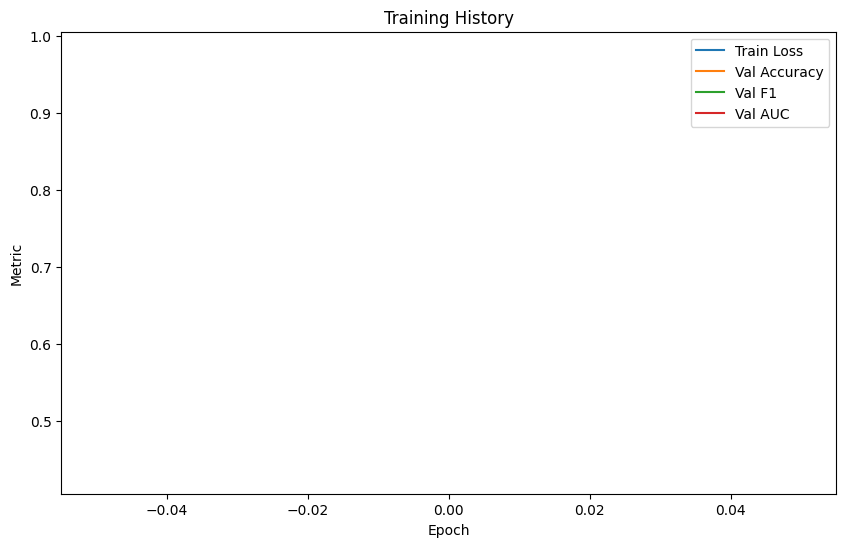

In [ ]:

# ----------------------------
# Plot training history
# ----------------------------
plt.figure(figsize=(10,6))
plt.plot(history["loss"], label="Train Loss")
plt.plot(history["val_acc"], label="Val Accuracy")
plt.plot(history["val_f1"], label="Val F1")
plt.plot(history["val_auc"], label="Val AUC")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()
plt.title("Training History")
plt.show()


In [ ]:
print("logits shape:", logits.shape, "y shape:", y.shape)

logits shape: torch.Size([31]) y shape: torch.Size([31])


In [ ]:
print(model)

CandidateNetMultimodal(
  (num_proj): Identity()
  (cat_emb): CategoricalEmbeddings(
    (embeddings): ModuleDict(
      (spg_number): Embedding(214, 50)
      (func): Embedding(2, 1)
      (dimensionality): Embedding(8, 4)
      (typ): Embedding(2, 1)
      (crys): Embedding(8, 4)
    )
  )
  (formula_emb): FormulaEmbedder(
    (emb): Embedding(89, 32)
  )
  (graph_enc): SimpleGraphEncoder(
    (atom_emb): Embedding(89, 64)
    (msg1): Linear(in_features=68, out_features=64, bias=True)
    (msg2): Linear(in_features=68, out_features=64, bias=True)
    (node_up1): Linear(in_features=64, out_features=64, bias=True)
    (node_up2): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=175, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): LayerNorm((64,), eps=1e-05, elementwi

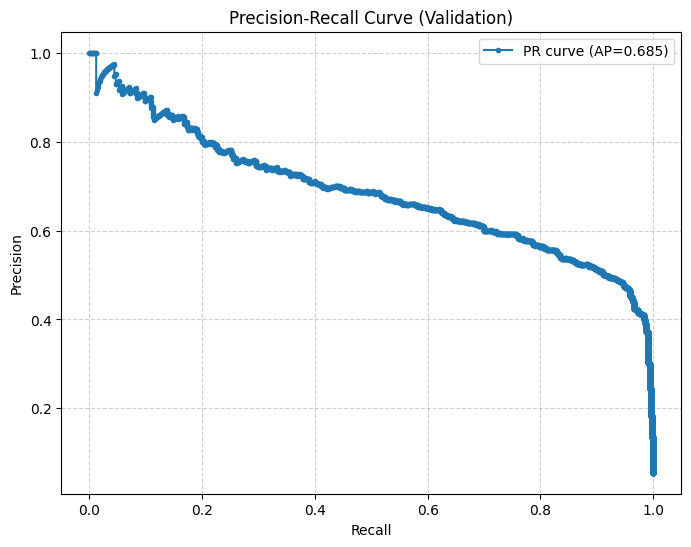

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Recall: y_true (0/1 labels) and y_prob (predicted probabilities)
precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
avg_prec = average_precision_score(y_true, y_prob)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.', label=f'PR curve (AP={avg_prec:.3f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Validation)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()



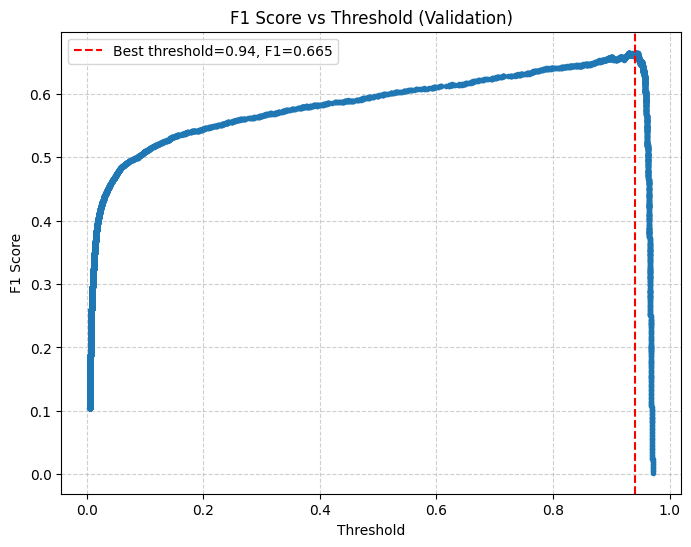

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score

# Recall: y_true (0/1 labels) and y_prob (predicted probabilities)
precision, recall, thresholds = precision_recall_curve(y_true, y_prob)

# Compute F1 for each threshold
f1_scores = []
for t in thresholds:
    y_pred = (y_prob >= t).astype(int)
    f1_scores.append(f1_score(y_true, y_pred))

# Plot F1 vs threshold
plt.figure(figsize=(8,6))
plt.plot(thresholds, f1_scores, marker='o', markersize=3)
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold (Validation)")
plt.grid(True, linestyle="--", alpha=0.6)

# Highlight the best threshold
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
plt.axvline(best_thresh, color="red", linestyle="--", label=f"Best threshold={best_thresh:.2f}, F1={best_f1:.3f}")
plt.legend()

plt.show()


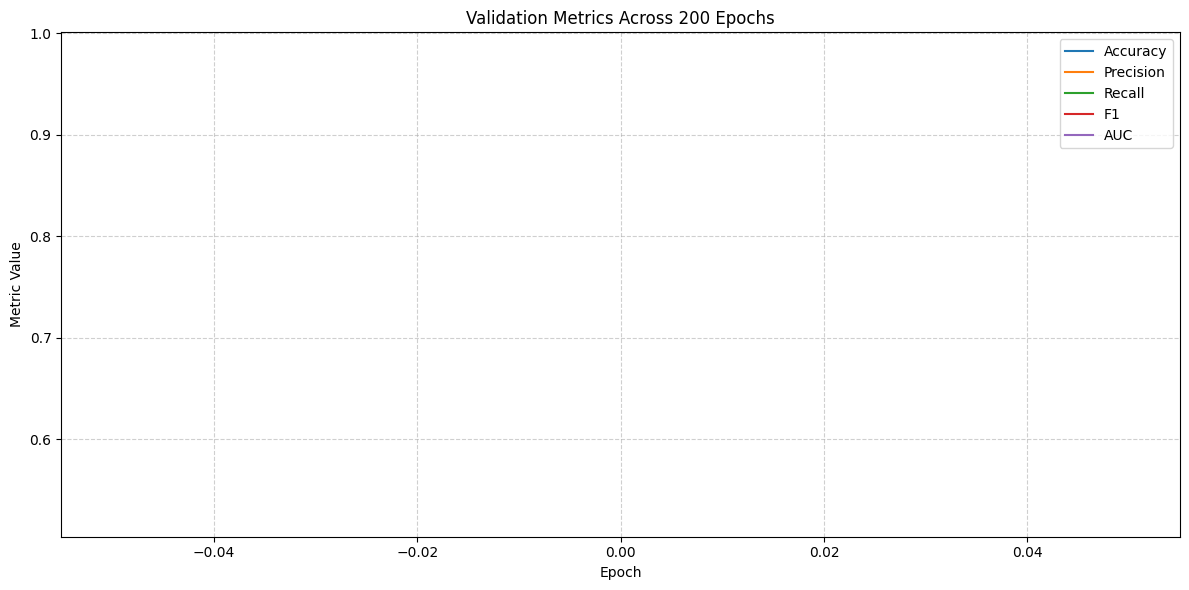

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(history["val_acc"], label="Accuracy")
plt.plot(history["val_prec"], label="Precision")
plt.plot(history["val_rec"], label="Recall")
plt.plot(history["val_f1"], label="F1")
plt.plot(history["val_auc"], label="AUC")


plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("Validation Metrics Across 200 Epochs")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate(model, loader, threshold=0.5, title="Evaluation"):
    """
    Run evaluation on a given DataLoader and print metrics + confusion matrix.
    """
    model.eval()
    y_true, y_prob = [], []

    with torch.no_grad():
        for X_num, X_cat_dict, counts, graph, y in loader:
            logits = model(X_num, X_cat_dict, counts, graph)
            probs = torch.sigmoid(logits).cpu().numpy().ravel()
            y_prob.extend(probs.tolist())
            y_true.extend(y.cpu().numpy().ravel().tolist())

    # Apply threshold
    y_pred = (np.array(y_prob) >= threshold).astype(int)

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    try:
        auc = roc_auc_score(y_true, y_prob)
    except Exception:
        auc = float("nan")

    print(f"{title} -- Acc: {acc:.3f} | Prec: {prec:.3f} | Rec: {rec:.3f} | F1: {f1:.3f} | AUC: {auc:.3f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=3))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Predicted Negative", "Predicted Positive"],
                yticklabels=["Actual Negative", "Actual Positive"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title} (Threshold={threshold})")
    plt.show()

    return acc, prec, rec, f1, auc


Validation -- Acc: 0.950 | Prec: 0.527 | Rec: 0.865 | F1: 0.655 | AUC: 0.978
Classification Report:
              precision    recall  f1-score   support

         0.0      0.992     0.955     0.973     14361
         1.0      0.527     0.865     0.655       838

    accuracy                          0.950     15199
   macro avg      0.759     0.910     0.814     15199
weighted avg      0.966     0.950     0.955     15199



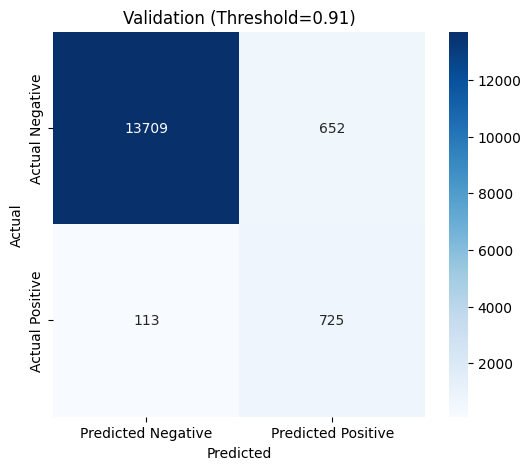

(0.9496677412987696,
 0.5265068990559186,
 0.8651551312649165,
 0.654627539503386,
 0.9783647338431003)

In [ ]:
evaluate(model, val_loader, threshold=model_cfg["threshold"], title="Validation")


## Materials Discovery

Full Dataset -- Acc: 0.952 | Prec: 0.541 | Rec: 0.873 | F1: 0.668 | AUC: 0.979
Classification Report:
              precision    recall  f1-score   support

         0.0      0.992     0.957     0.974     71804
         1.0      0.541     0.873     0.668      4189

    accuracy                          0.952     75993
   macro avg      0.767     0.915     0.821     75993
weighted avg      0.967     0.952     0.957     75993



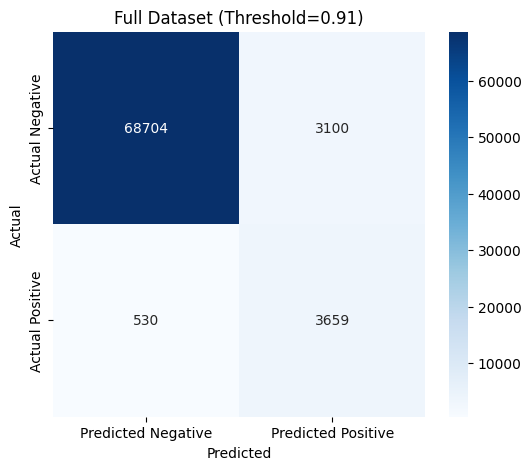

(0.9522324424618057,
 0.5413522710460127,
 0.8734781570780615,
 0.6684325904274754,
 0.9789014570831324)

In [ ]:
evaluate(model, full_loader, threshold=model_cfg["threshold"], title="Full Dataset")

## Checkpoint

In [ ]:
# ----------------------------
# Save checkpoint
# ----------------------------
if False:  # Change to True to enable saving
    if checkpoint_path:
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "history": history,
            "config": model_cfg
        }, checkpoint_path)
        logger.info(f"Checkpoint saved to {checkpoint_path}")
